In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import h5py
import glob
from helper.general import *
from helper.plotting import *
plt.style.use('seaborn-colorblind')
%matplotlib inline
#  matplotlib.rcParams.update({'font.size': 16})

In [2]:
# Set colormap for different image types
cmap_img_type = {}
cmap_img_type['water'] = 'gray'
cmap_img_type['fat'] = 'gray'
cmap_img_type['silicone'] = 'gray'
cmap_img_type['fieldmap'] = 'magma'
cmap_img_type['fatFraction_percent'] = 'inferno'

In [3]:
temperature_shift_ppm = 0.14

# Peanut oil's fat model: 10.1016/j.mri.2011.07.004
F = Fatmodel(cl=17.97, ndb=3.48, nmidb=1.01, modelname='Berglund 10 peaks')
F.compute_fatmodel()
fatmodel_peanut = {}
fatmodel_peanut['freqs_ppm'] = F.deshielding_ppm - temperature_shift_ppm
fatmodel_peanut['relAmps'] = F.relamps_percent / 100
silicone_freq_ppm = - 4.9 - temperature_shift_ppm

## Processing

In [1]:
## This cell has a long execution time; the results are saved in data/processed/phantom_*.h5
files = ['breastTE', 'shortest']
echoes = [6, 4]
results = {}

for file in files:
    processing = h5py.File(f'./data/phantom/processed/phantom_{file}.h5', 'w')
    source = h5py.File(f'./data/phantom/phantom_{file}.h5', 'r')
    
    signal_2dyn = source['multiecho']
    for dyn in range(signal_2dyn.shape[-2]):
        print(f'{file}, dynamic {dyn+1}')
        signal = signal_2dyn[..., dyn, :]
        params = {}
        params.update(source['multiecho'].attrs)
        params['FatModel'] = fatmodel_peanut
        params['siliconePeak_ppm'] = silicone_freq_ppm

        mip = np.sqrt(np.sum(np.abs(signal)**2, axis=-1))
        mask = mip > 2.5 / 100 * np.max(mip)
        grp = processing.create_group(f'dynamic {dyn}')
        
        for num_echoes in echoes:
            print(f'{file}, {num_echoes} echoes')

            params['TE_s'] = params['TE_s'][:num_echoes]
            signal = signal[:,:,:,:num_echoes]

            g = MultiEcho(signal, mask, params)
            g.range_fm *= 1
            g.r2star_correction = False

            g.perform()

            grp_echoes = grp.create_group(f'{num_echoes} echoes')

            save_params = ['water', 'fat', 'silicone', 'fatFraction_percent', 'fieldmap', 'r2starmap']
            for save_param in save_params:
                if save_param == 'fieldmap':
                    param = grp_echoes.create_dataset(f'{save_param}', data=g.fieldmap, 
                                               compression='gzip')
                elif save_param == 'r2starmap':
                    param = grp_echoes.create_dataset(f'{save_param}', data=g.r2starmap, 
                                               compression='gzip')
                else:
                    param = grp_echoes.create_dataset(f'{save_param}', data=g.images[f'{save_param}'], 
                                               compression='gzip')
    print('')
    processing.close()

NameError: name 'h5py' is not defined

## Phantom separation (Fig. 5)

shortest, 6 echoes


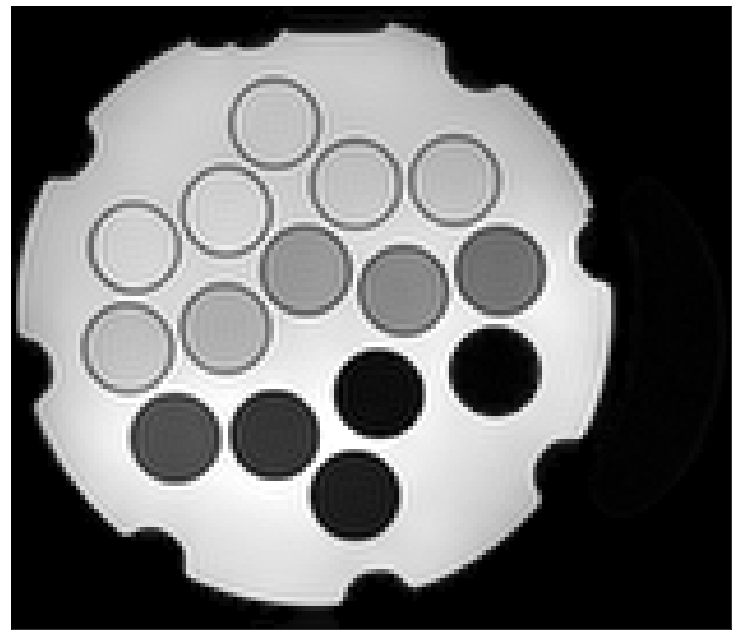

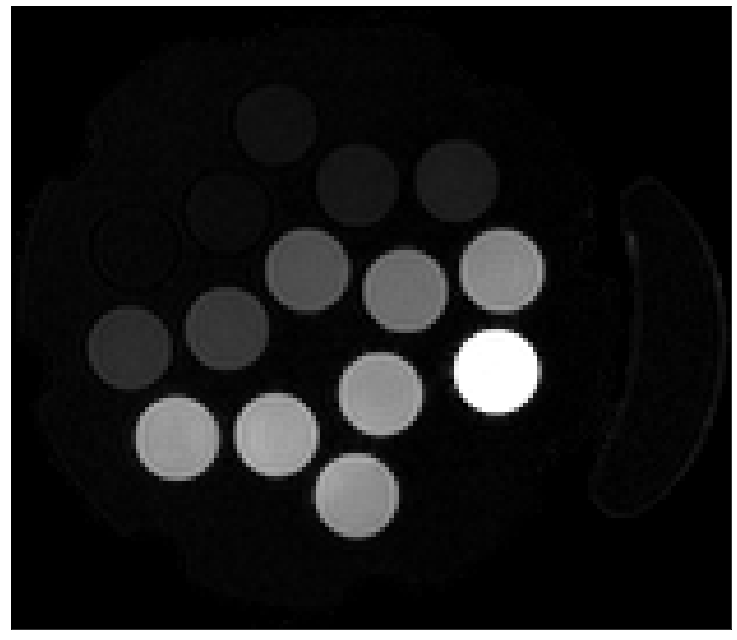

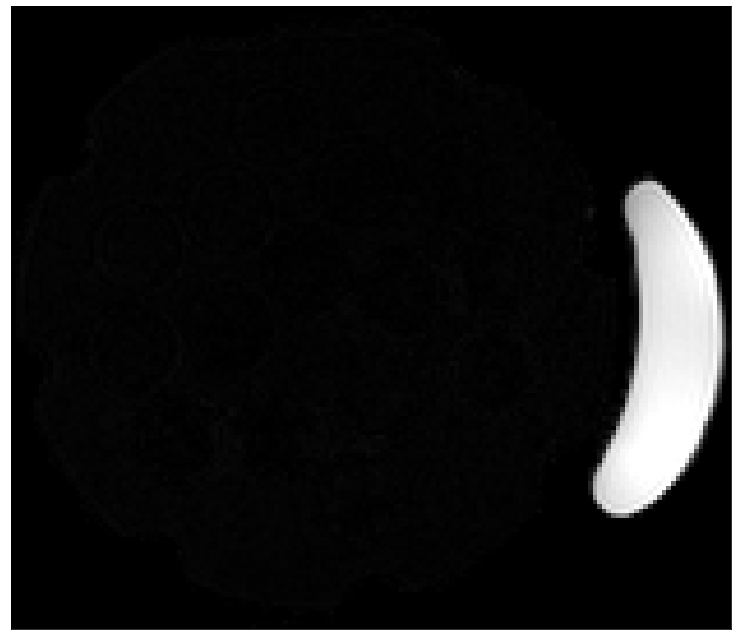

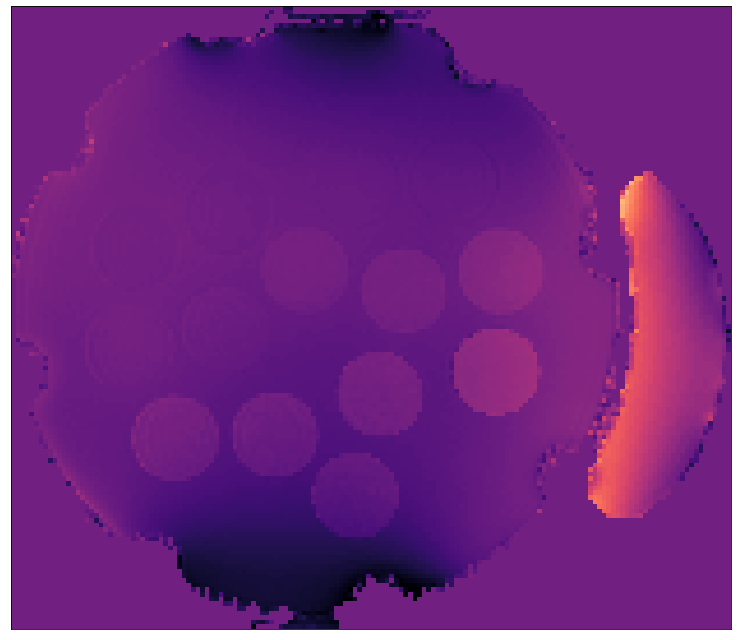

shortest, 4 echoes


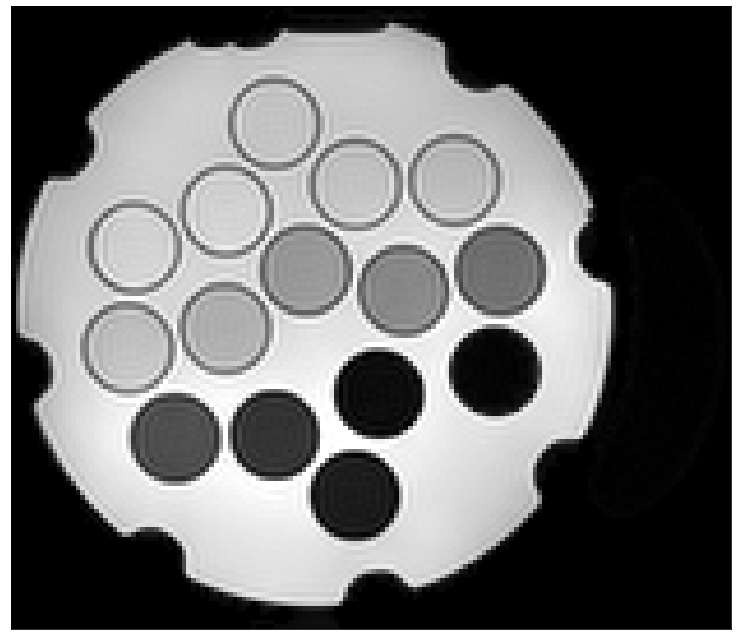

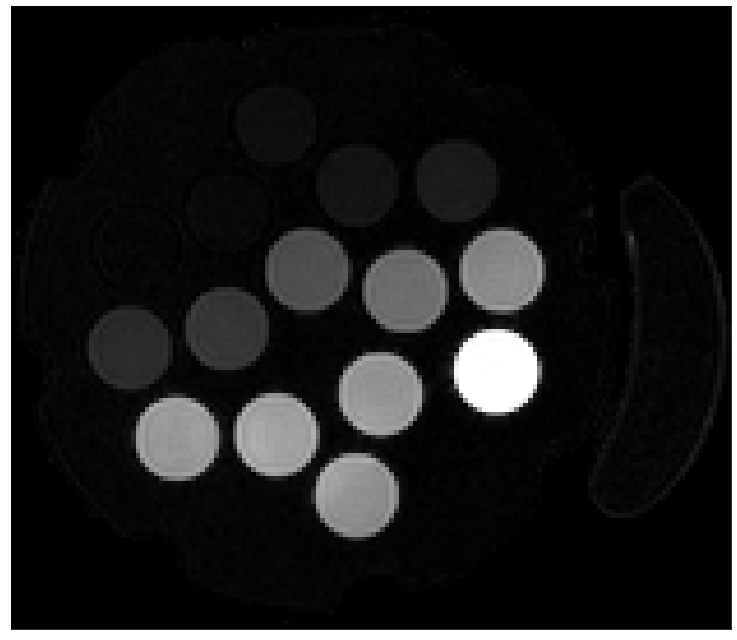

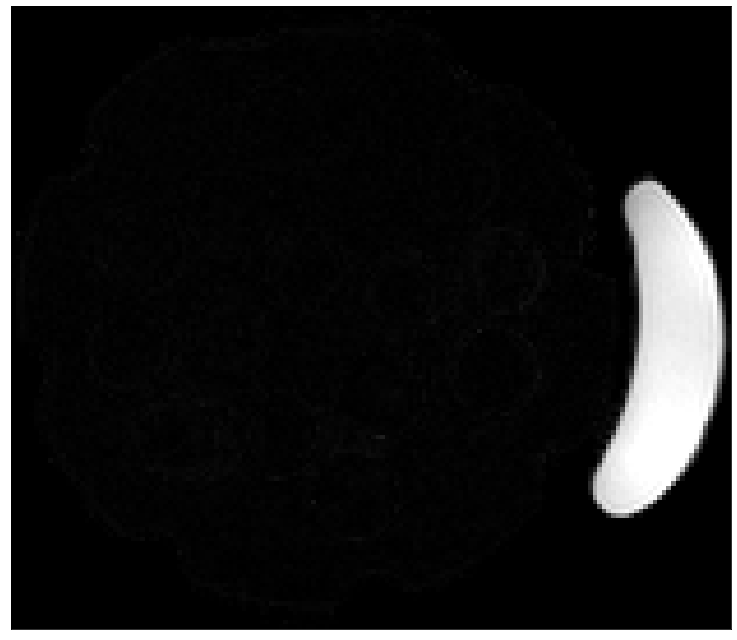

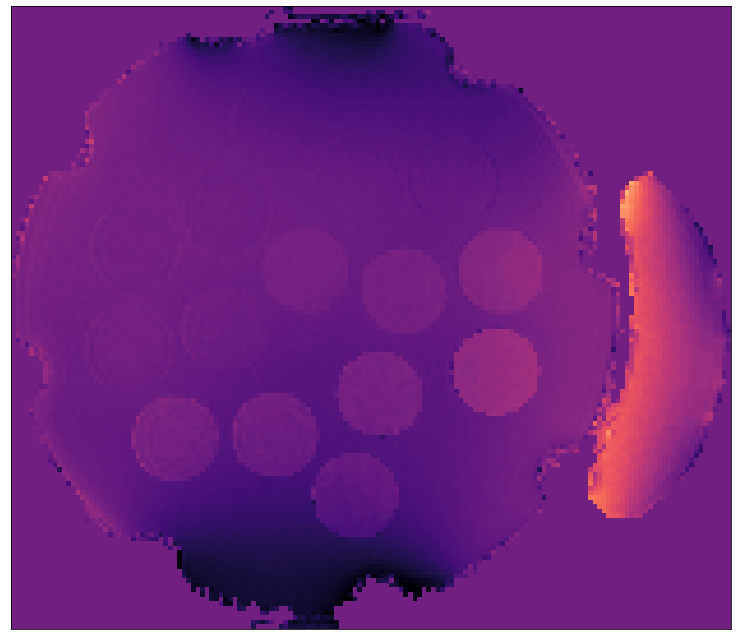

breastTE, 6 echoes


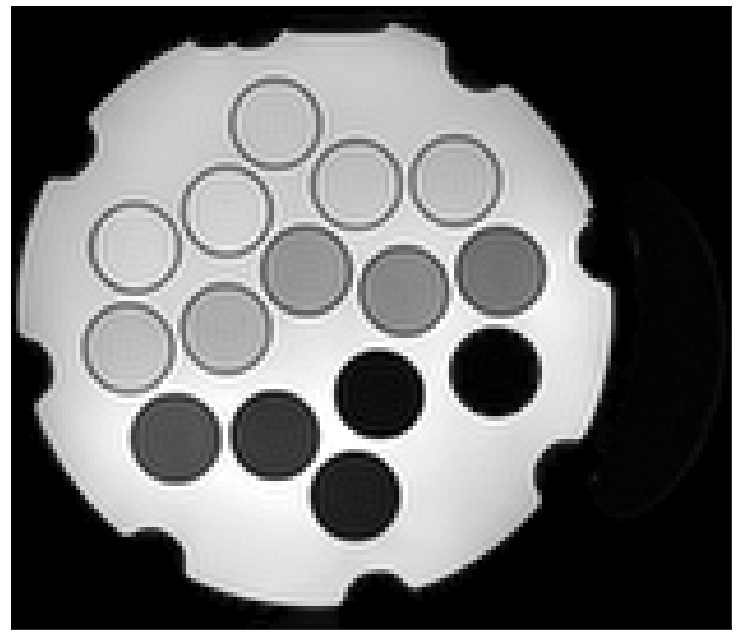

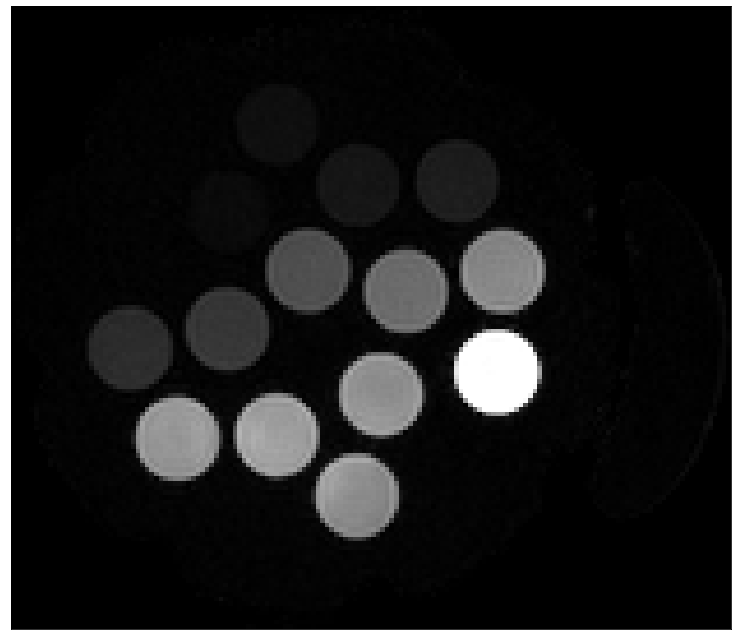

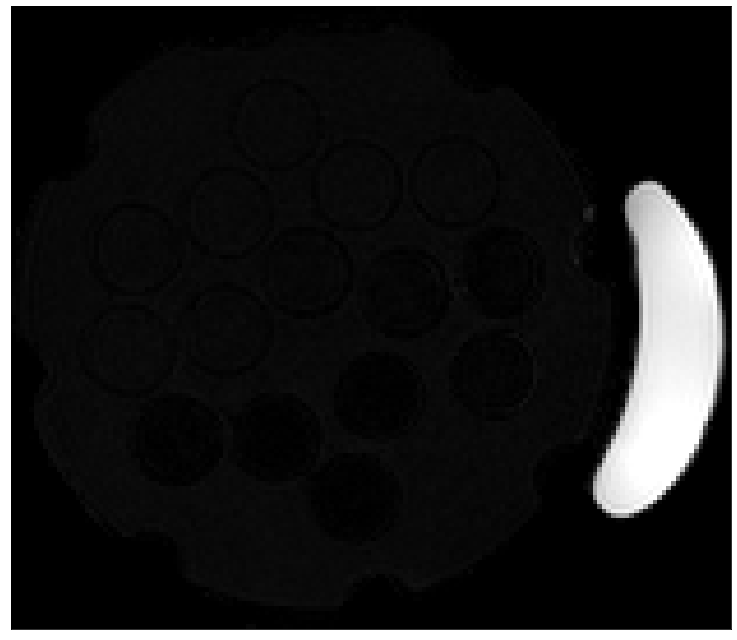

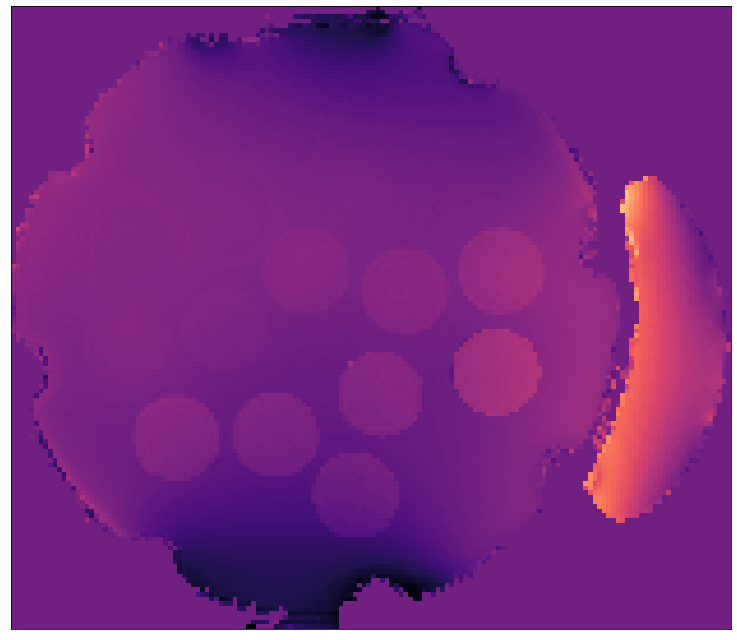

breastTE, 4 echoes


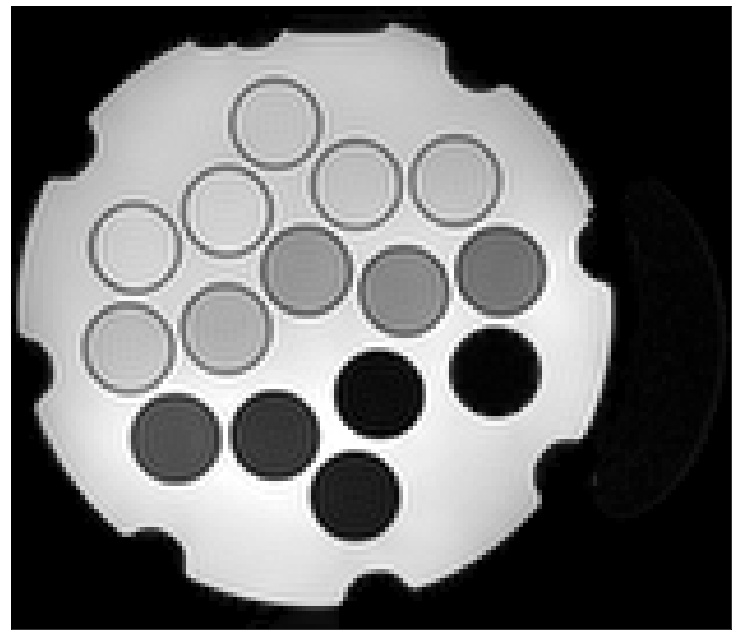

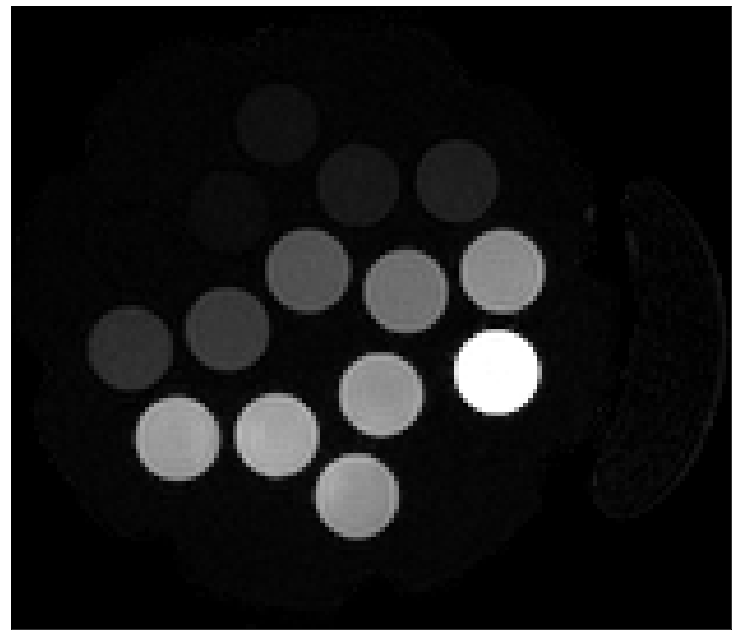

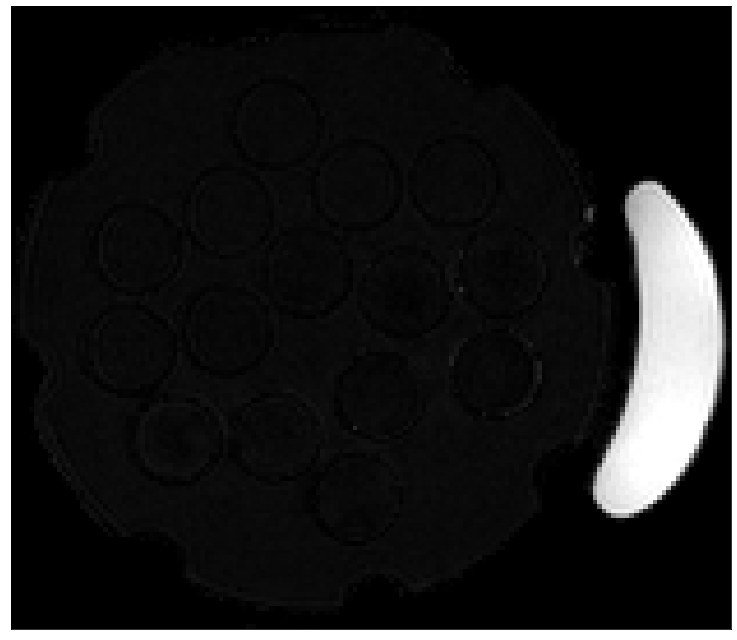

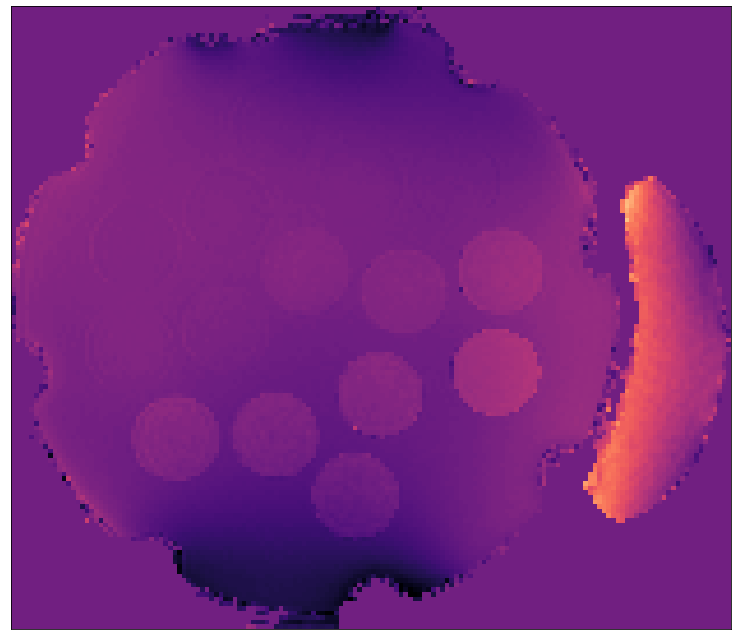

In [4]:
from hmrGC.dixon_imaging.helper import calculate_pdsf_percent
fig_name = "phantom_separation"
os.makedirs(f'./figures/{fig_name}', exist_ok=True)

for echoes_spacing in ['shortest', 'breastTE']:
    source = h5py.File(f'./data/phantom/phantom_{echoes_spacing}.h5', 'r')
    processed = h5py.File(f'./data/phantom/processed/phantom_{echoes_spacing}.h5', 'r')
    for echoes_number in ['6 echoes', '4 echoes']:
        print(f'{echoes_spacing}, {echoes_number}')
        for img_type in ['water', 'fat', 'silicone', 'fieldmap']:
            img = np.array(processed['dynamic 0'][echoes_number][img_type])
            voxelsize = source['multiecho'].attrs['voxelSize_mm']
            filename = f'phantom_{echoes_number[0]}_echoes_{echoes_spacing}_{img_type}'
            if img_type == 'fieldmap':
                limits = [-100, 200]
                
                plot_images(img, cmap_img_type[img_type], ['axial'], voxelsize, [64, 0, 0], limits,
                            filename=filename, fig_name=fig_name)
            else:
                img = np.abs(img)
                limits = None #[0,  np.percentile(img, 99)]
            
                plot_images(img, cmap_img_type[img_type], ['axial'], voxelsize, [64, 0, 0], limits,
                            filename=filename, fig_name=fig_name, plot_cmap=False)

In [5]:
# Silicone ROI
size = [15, 5, 0]
roi = [90, 145, 64]
roi_phantom = [80, 70, 64]
size_phantom = [15, 15, 0]

for echoes_spacing in ['shortest', 'breastTE']:
    source = h5py.File(f'./data/phantom/phantom_{echoes_spacing}.h5', 'r')
    processed = h5py.File(f'./data/phantom/processed/phantom_{echoes_spacing}.h5', 'r')
    for echoes_number in ['6 echoes', '4 echoes']:
        print(f'{echoes_spacing}, {echoes_number}')
        for img_type in ['silicone']:
            img = np.array(processed['dynamic 0'][echoes_number][img_type])

            # PDSF evaluation
            pdsf = calculate_pdsf_percent(np.array(processed['dynamic 0'][echoes_number]['water']),
                                          np.array(processed['dynamic 0'][echoes_number]['fat']),
                                          img)
            values = pdsf[roi[0]-size[0]:roi[0]+size[0], roi[1]-size[1]:roi[1]+size[1], roi[2]]
            print(f'PDSF: {np.mean(values)} pm {np.std(values)}')

            # SNR estimation
            img = np.abs(img)
            img2 = np.abs(np.array(processed['dynamic 1'][echoes_number][img_type]))
            values1 = img[roi[0]-size[0]:roi[0]+size[0], roi[1]-size[1]:roi[1]+size[1], roi[2]]
            values1_phantom = img[roi_phantom[0]-size_phantom[0]:roi_phantom[0]+size_phantom[0], roi_phantom[1]-size_phantom[1]:roi_phantom[1]+size_phantom[1], roi_phantom[2]]
            values2 = img2[roi[0]-size[0]:roi[0]+size[0], roi[1]-size[1]:roi[1]+size[1], roi[2]]
            values2_phantom = img2[roi_phantom[0]-size_phantom[0]:roi_phantom[0]+size_phantom[0], roi_phantom[1]-size_phantom[1]:roi_phantom[1]+size_phantom[1], roi_phantom[2]]
            signal = np.mean(values1 + values2)
            signal_phantom = np.mean(values1_phantom + values2_phantom)
            noise = np.std(values1 - values2)
            print(f'SNR: {1/np.sqrt(2)*signal/noise}')
            print(f'S/S0: {signal/signal_phantom}')

shortest, 6 echoes
PDSF: 102.60531616210938 pm 1.0112255811691284
SNR: 247.49309434774565
S/S0: 73.88533782958984
shortest, 4 echoes
PDSF: 98.94226837158203 pm 1.8727774620056152
SNR: 139.72926605916692
S/S0: 74.70673370361328
breastTE, 6 echoes
PDSF: 99.90518188476562 pm 1.382554054260254
SNR: 276.39564558053735
S/S0: 34.18722915649414
breastTE, 4 echoes
PDSF: 97.71695709228516 pm 1.8482375144958496
SNR: 108.83744343162763
S/S0: 28.022733688354492


## PDFF quantification (Fig. 6)

In [6]:
# Load MRS fitting results
PDFF_TIMGRE = np.zeros((15))
PDFF_MRS = np.zeros((15))
for path in sorted(glob.glob(f'./data/mrs/*.mat')):
    vial = int(path.split('_')[-1][:-6])
    quant = get_BMRS_quantification(path)
    PDFF_MRS[vial-1] = np.sum(quant['rho'][:-1])/np.sum(quant['rho'])*100
PDFF_MRS[0] = 0

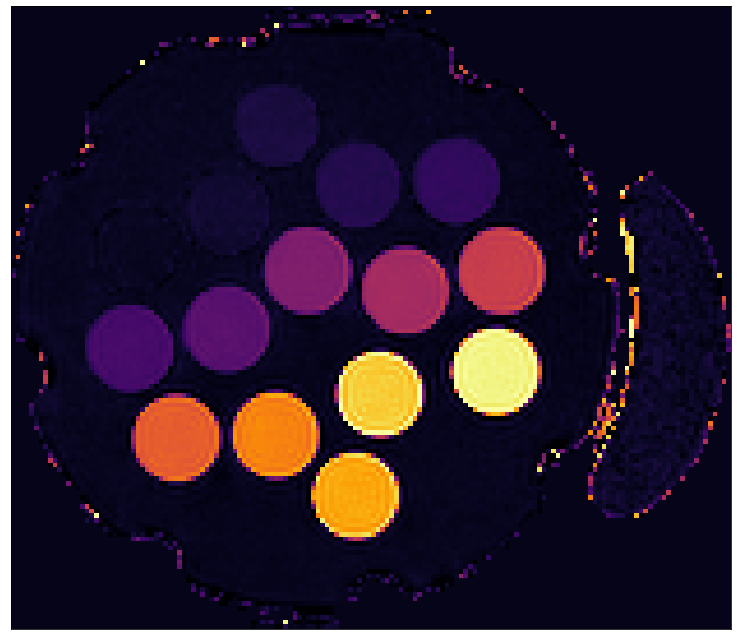

[]

In [7]:
fig_name = 'phantom_quantification'
os.makedirs(f'./figures/{fig_name}', exist_ok=True)

source = h5py.File(f'./data/phantom/phantom_shortest.h5', 'r')
processed = h5py.File(f'./data/phantom/processed/phantom_shortest.h5', 'r')
img = np.array(processed['dynamic 0']['4 echoes']['fatFraction_percent'])
voxelsize = source['multiecho'].attrs['voxelSize_mm']
filename = f'phantom_6_echoes_shortest_PDFF'
limits = [-5, 105]

plot_images(img, cmap_img_type['fatFraction_percent'], ['axial'], voxelsize, [64, 0, 0], limits,
            filename=filename, fig_name=fig_name, plot_cmap=True)

6 echoes, shortest TE, $R^2$ = 99.88%
99.87998429946205
6 echoes, breast TE, $R^2$ = 99.89%
99.88767178585739
4 echoes, shortest TE, $R^2$ = 99.92%
99.91615691075411
4 echoes, breast TE, $R^2$ = 99.96%
99.96320625157699


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


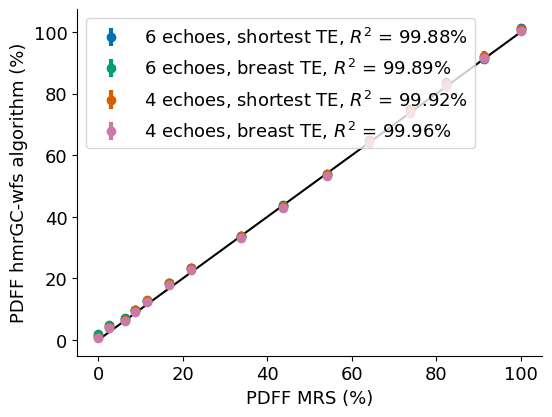

In [8]:
vials = [(PDFF_MRS[0], [65, 27]), #1
         (PDFF_MRS[1], [57, 47]), #2 
         (PDFF_MRS[2], [38, 58]), #3
         (PDFF_MRS[3], [51, 75]), #4
         (PDFF_MRS[4], [50, 100]), #5
         (PDFF_MRS[5], [87, 26]), #6
         (PDFF_MRS[6], [83, 48]), #7
         (PDFF_MRS[7], [71, 65]), #8
         (PDFF_MRS[8], [75, 85]), #9
         (PDFF_MRS[9], [71, 107]), #10
         (PDFF_MRS[10], [107, 37]), #11
         (PDFF_MRS[11], [107, 58]), #12
         (PDFF_MRS[12], [120, 76]), #13
         (PDFF_MRS[13], [97, 81]), #14
         (PDFF_MRS[14], [92, 106]),] #15
size = [5, 5, 10]

PDFF = {}
for echoes_spacing in ['shortest', 'breastTE']:
    processed = h5py.File(f'./data/phantom/processed/phantom_{echoes_spacing}.h5', 'r')
    PDFF[echoes_spacing] = {}
    for echoes_number in ['4 echoes', '6 echoes']:
        PDFF[echoes_spacing][echoes_number] = {}
        img = np.array(processed['dynamic 0'][echoes_number]['fatFraction_percent'])
        center = img.shape[2] // 2
        for i, (expected, vial) in enumerate(vials):
            PDFF_tmp = img[vial[0]-size[0]:vial[0]+size[0], vial[1]-size[1]:vial[1]+size[1],
                           center-size[2]:center+size[2]]
            PDFF[echoes_spacing][echoes_number][i] = (np.mean(PDFF_tmp), np.std(PDFF_tmp))
            
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
labels = ['6 echoes, shortest TE, $R^2$ = 99.88%', '6 echoes, breast TE, $R^2$ = 99.89%',
          '4 echoes, shortest TE, $R^2$ = 99.92%', '4 echoes, breast TE, $R^2$ = 99.96%']
plt.style.use('default')
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(figsize=(4*1.5,3*1.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pos = 0
for j, echoes_spacing in enumerate(PDFF.keys()):
    for k, echoes_number in enumerate(PDFF[echoes_spacing].keys()):
        val = []
        refs = []
        l = 2*j + k
        for i in PDFF[echoes_spacing][echoes_number].keys():
            ref = vials[i][0]
            values = PDFF[echoes_spacing][echoes_number][i]
            refs.append(ref)
            val.append(values[0])
            if i == 1:
                ax.errorbar(ref, values[0], yerr=values[1], fmt='o',
                            color=colors[l], label=labels[l], elinewidth=3)
            else:
                ax.errorbar(ref, values[0], yerr=values[1], fmt='o',
                            color=colors[l], elinewidth=3)
        val = np.array(val)
        refs = np.array(refs)
        ss_tot = np.sum((val-np.mean(val))**2)
        ss_res = np.sum((val-refs)**2)
        r2 = 1 - (ss_res / ss_tot)
        print(labels[l])
        print(r2*100)

ax.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100), color='black')
ax.legend()
ax.set_ylabel('PDFF hmrGC-wfs algorithm (%)')
ax.set_xlabel('PDFF MRS (%)')
filename = 'PDFF_phantom_CSE-WFS_MRS'
plt.savefig(f'./figures/{fig_name}/{filename}.eps')
plt.show()